# This notebook 
#### 1. Get the time series from the selected lakes
#### 2. Get data from selected lakes
#####    - Lake shapefile, area
#####    - Lake ice
#### 3. Preprocess ground observation of the selected lakes individually
#### 4. Save dataframe will all the time series preprocessed 
#### 5. Preprocess altis data of the selected lakes 
#### 6. Generate the matching time series of ground and altimeter observations

# Libraries to import 

In [51]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols, convert_units and all the functions 
from ts_plots import *

import geopandas as gpd
import platform
import scipy.interpolate as sc
import geopandas as gpd
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz

from timezonefinder import TimezoneFinder
from pytz import timezone
import timeit
from datetime import datetime
from icecream import ic

utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

# 1. Get the time series from the selected lakes
###  Getting locss stations

In [52]:
# Getting locss stations

go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2', 'CQK2', 'SKT2', 'MCW2', 'PAW2', 'MRP2', 'SPA2', 'BLB2','RLH2','MTN2', 'VCN2', 'FDN2']

####NOTE
#VNC2 is the other gauge in Mattamuskeet 
#FDN2 is the other gauge in Phelps


#Read only data from the lakes with the codes specified in lc_lakes
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True) #Expand date details in coloumns
stations=df_locss['gauge_id'].unique()

#Unify all the units to the metric system
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', unit_fd='unit',
                  gauge_fd='gauge_id')

#Extract gauges that are not operational less than 2 data
lk_id_fd='gauge_id'

df_readings_count=df_final.groupby([lk_id_fd], as_index=False).size()
no_operational_gauges=df_readings_count.loc[df_readings_count['size']<=2][lk_id_fd]

print('Initial size',df_final.shape)
df_final=df_final.loc[~df_final[lk_id_fd].isin(no_operational_gauges)]
print('Final size',df_final.shape)

#Calculate the differences between consecutive values and dates
#Remove and process duplicate dates

cut_off=0.05 #cut_off for the standard deviation

gauges_list=lc_lakes#df_final[st_id].unique()

date_fd='date'
cols=['gauge_id', 'name', 'date', 'time', 
       'min_height', 'max_height', 'unit', 'source',
       'year', 'month', 'day', 'hour', 'decimal_y']

#use help to see the desciption of filter_extreme_duplicates. i.e., help(filter_extreme_duplicates)         
df_final_nd=filter_extreme_duplicates(df_final, lk_id_fd, date_fd,height_fd, cols, cut_off, gauge_list=gauges_list)
df_final_nd.rename(columns={'height_rc':height_fd}, inplace=True)

#Extract the ones with duplicates from df_final
df_temp=df_final.loc[~df_final[lk_id_fd].isin(df_final_nd[lk_id_fd].unique())]
df_temp=pd.concat((df_temp, df_final_nd), axis=0)


Initial size (4008, 18)
Final size (4006, 18)


# 1. Get the time series from the selected lakes
### Getting ARHN stations from file
### Getting USGS stations from file. Still working on R script connection to get them from USGS
### Getting Brazilian Reservoirs from file

In [53]:
# Getting ARHN stations 

# #'2102' Is a meteorlogical station 
ar_lakes=['1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']#'1805', '1819',
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

# Getting USGS stations from file. Still working on R script connection
us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', 
                  gauge_fd='gauge_id')

# Getting Brazilian Reservoirs
rvbr_lakes=['19069','19060','19126', '12030', '12036', '12327','12056']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

#### Concat all the ground observations in a single dataframe

In [54]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
# df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_temp[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)

df_ground_ts['doy']=df_ground_ts['date'].dt.dayofyear
df_ground_ts.shape
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
# df_ground_ts.columns

(362813, 10)

# 2. Get data from selected lakes
###   - Lake shapefile, area, lake name
###   - Lake ice
###  Generate the file with all the initial preprocesing 

In [55]:
#Get selected lakes 
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_wgs84_f.shp'
else:
    path_lakes='C:/Users/amgomez/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_wgs84_f.shp'

df_sel_lakes=gpd.read_file(path_lakes)

#merge name based on gauge_id
df_lake_name=df_sel_lakes[['gauge_id','lake_name']]
df_ground_ts=pd.merge(df_ground_ts, df_lake_name, on='gauge_id',how='left')

In [56]:
#Add the ice covered from Xiao's code

df_ice=pd.read_csv('../data/locss_ice.csv')
df_ice
df_ice=pd.merge(df_ice, df_sel_lakes[['Hylak_id', 'gauge_id']], on='Hylak_id', how='left')
df_ground_ts=pd.merge(df_ground_ts, df_ice[['Hylak_id', 'gauge_id','SLIDE_snowIce','doy']], on=['gauge_id','doy'], how='left')


# 3. Preprocess ground observation of the selected lakes individually

In [57]:
# first, create a copy just in case
df_ground_ts_org=df_ground_ts.copy()

In [25]:
# df_ground_ts=df_ground_ts_org.copy()

In [58]:
#Function to plot before and after 
def plot_ts_preproc(df_before, df_after, st_id, date_fd, height_fd, title):
    
    df1=df_before
    df1=df1.sort_values(by=date_fd)
    plt.figure(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' before'+title)

    df1=df_after
    df1=df1.sort_values(by=date_fd)
    plt.figure(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' after'+ title)
    

### Extract and move reference point of the stations KHB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well


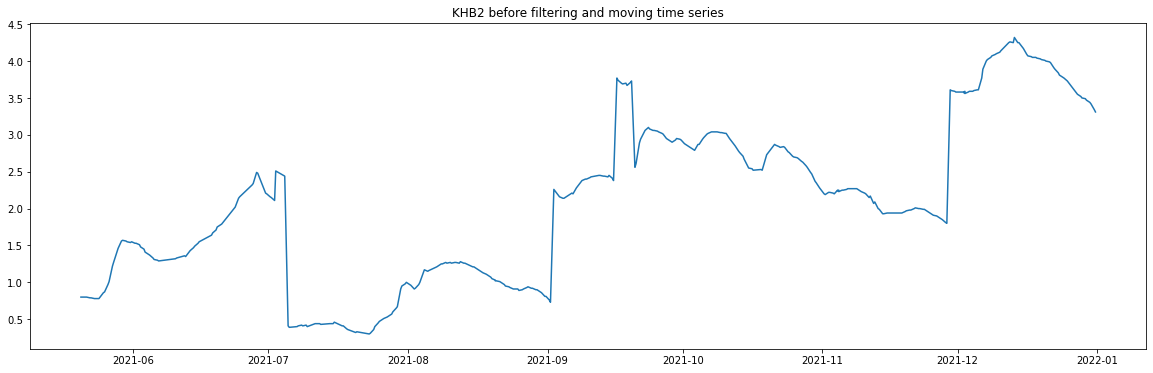

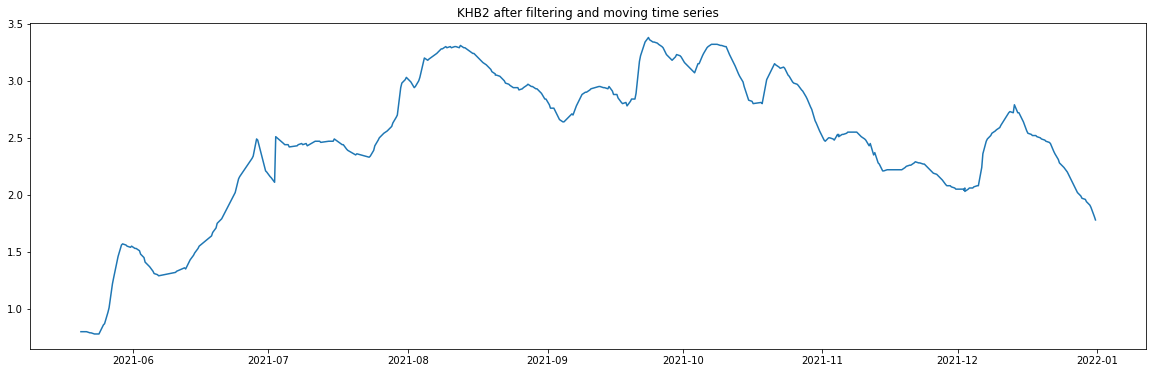

In [59]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='KHB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

date_fd='date'
diff_fd='diff'
df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
title=' filtering and moving time series'
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Extract and move reference point of the stations TAB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well

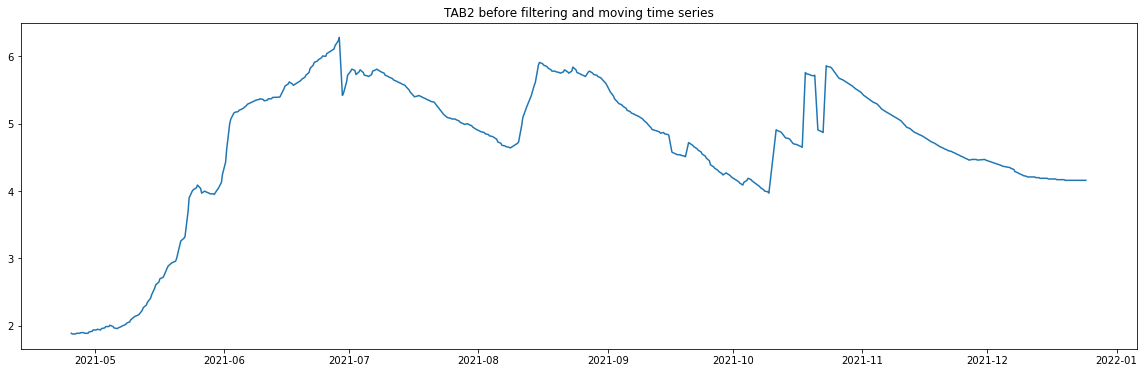

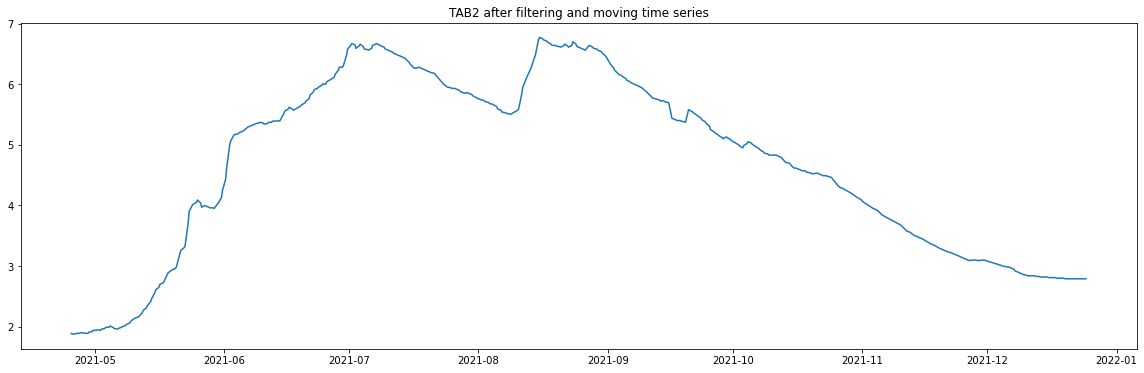

In [60]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='TAB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

date_fd='date'
diff_fd='diff'
df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
title=' filtering and moving time series'
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Extract anomalous values stations MTN2 (Lake Mattamuskeet West)
#### Reason: There is a extreme value TO-DO: Pending to describe this better

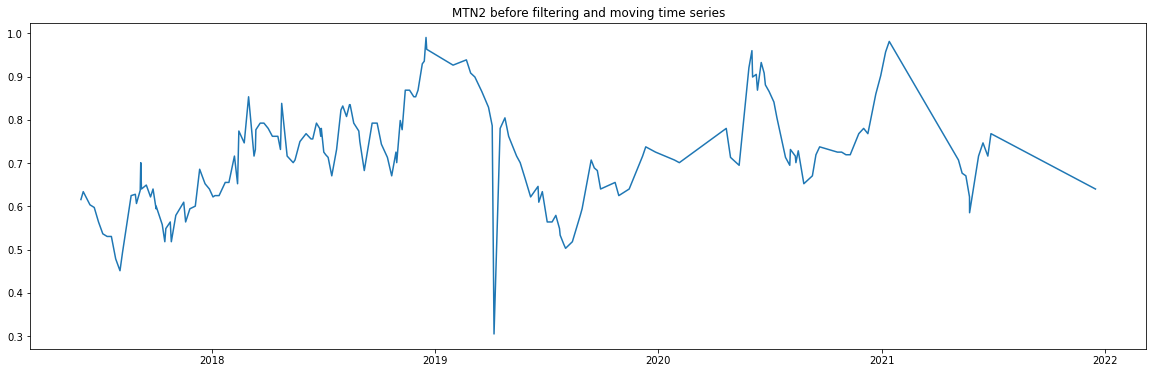

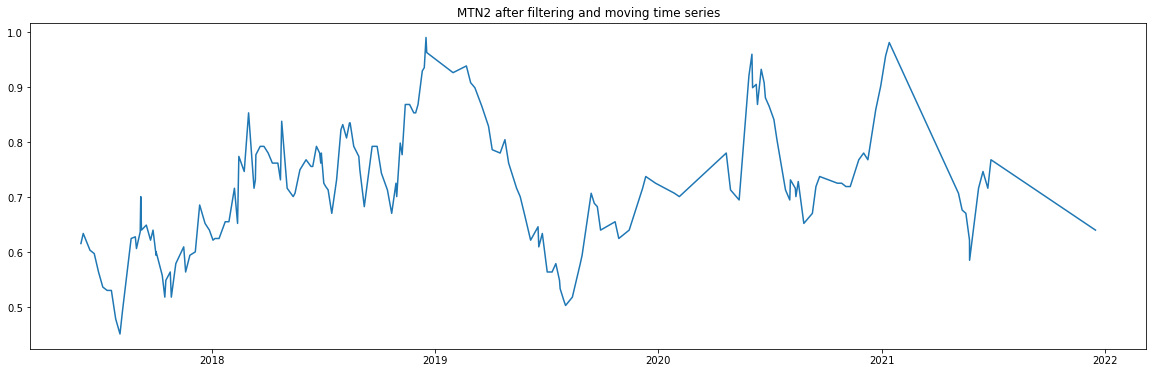

In [61]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='MTN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
title=' filtering and moving time series'
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


In [ ]:
### Extract anomalous values stations VCN2 (Lake Mattamuskeet West)
#### Reason: There is a extreme value TO-DO: Pending to describe this better

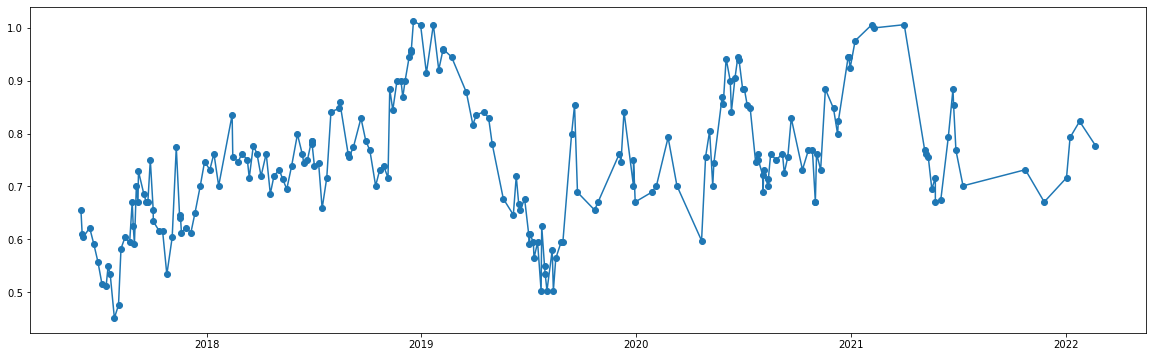

In [62]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='VCN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

plt.figure(figsize=(20, 6))

df1=df_ground_ex
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2')
# df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
# df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

# #plot goes in here
# title=' filtering and moving time series'
# plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)

In [69]:
df_ground_ex[['diff']].max()

diff    0.204216
dtype: float64

### Explore other gauge in Lake Mattamuskeet VCN2 (Lake Mattamuskeet est)
### Plot VCN2 and MTN2

(210, 15) (185, 15)


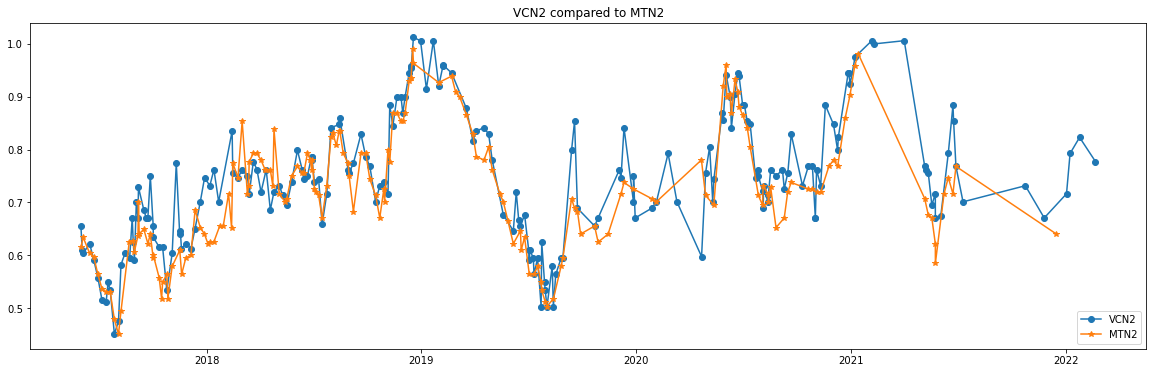

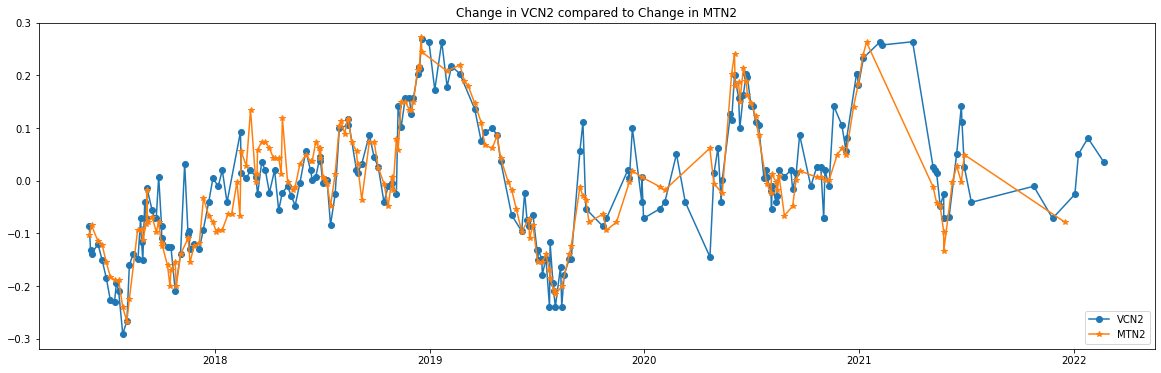

In [70]:
df_MTN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='MTN2'].copy()

df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='VCN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

# df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

# df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
# df_ground_ts=df_ground_expd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
# df1=df_ground_ex

plt.figure(figsize=(20, 6))

df1=df_ground_ex
df1=df1.sort_values(by=date_fd)
# plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', label='VCN2')
plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2')
df2=df_MTN2
df2=df2.sort_values(by=date_fd)
# plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2')
plt.plot(df2[date_fd], df2[height_fd], marker='*', label='MTN2')
plt.title(st_id+' compared to '+'MTN2')
plt.legend(loc='lower right')

plt.figure(figsize=(20, 6))

df1=df_ground_ex
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', label='VCN2')
# plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2')
df2=df_MTN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2')
# plt.plot(df2[date_fd], df2[height_fd], marker='*', label='MTN2')
plt.title('Change in ' + st_id+' compared to Change in '+'MTN2')
plt.legend(loc='lower right')

print (df1.shape, df2.shape)

(119, 15) (302, 15)
(119, 15) (302, 15)


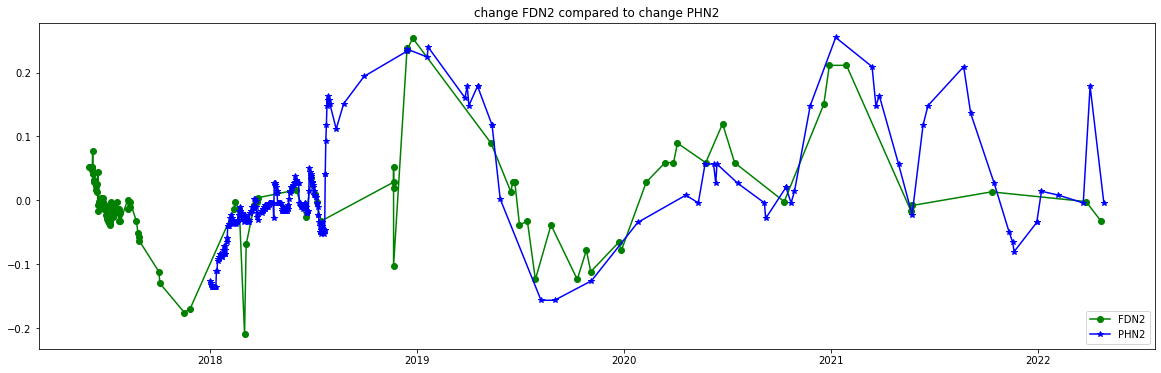

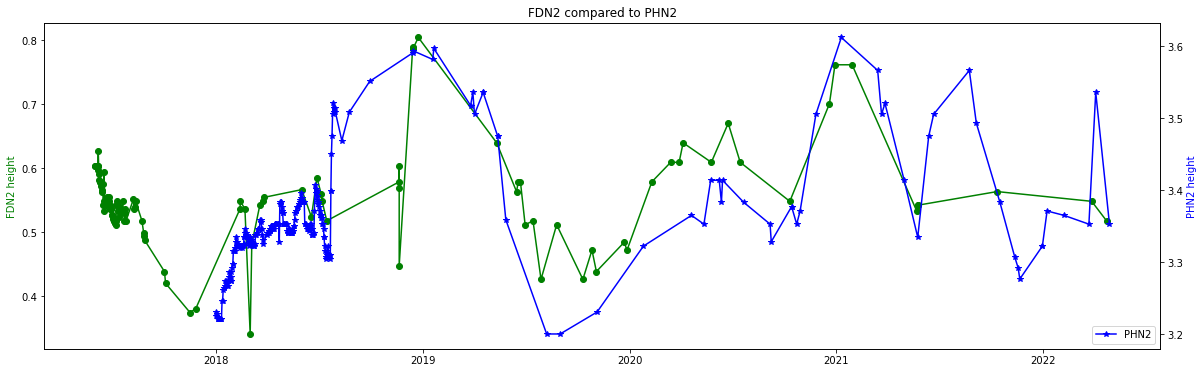

In [89]:
df_PHN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='PHN2'].copy()

df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='FDN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_ground_ex_PH, df_ground_re_PH,df_diff_to_remove_PH=extract_data_gauge(df_PHN2, st_id_fd, 'PHN2', date_fd, height_fd, low_lim, high_lim)

# df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
# df_ground_ts=df_ground_expd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
# df1=df_ground_ex

plt.figure(figsize=(20, 6))

df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), 'g-',marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(),'b-', marker='*', label='PHN2')
plt.title('change '+st_id+' compared to change '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

fig, ax=plt.subplots(figsize=(20, 6))

ax2=ax.twinx()
df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
ax.plot(df1[date_fd], df1[height_fd], 'g-', marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
ax2.plot(df2[date_fd], df2[height_fd], 'b-',marker='*', label='PHN2')

ax.set_ylabel('FDN2 height', color='g')
ax2.set_ylabel('PHN2 height', color='b')
plt.title(st_id+' compared to '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

In [87]:
df_ground_ex.loc[df_ground_ex['diff']==df_ground_ex[['diff']].max().values[0]]


,gauge_id,source,decimal_y,height,date,year,month,day,hour,doy,lake_name,Hylak_id,SLIDE_snowIce,diff,diff_time
338582,FDN2,LOCSS,2018.951826,0.789432,2018-12-14 10:41:49,2018,12,14,10,348,NaN,NaN,NaN,0.341376,0.065411


### Extract anomalous values stations 12327
#### Reason: There is a extreme value TO-DO: Pending to describe this better

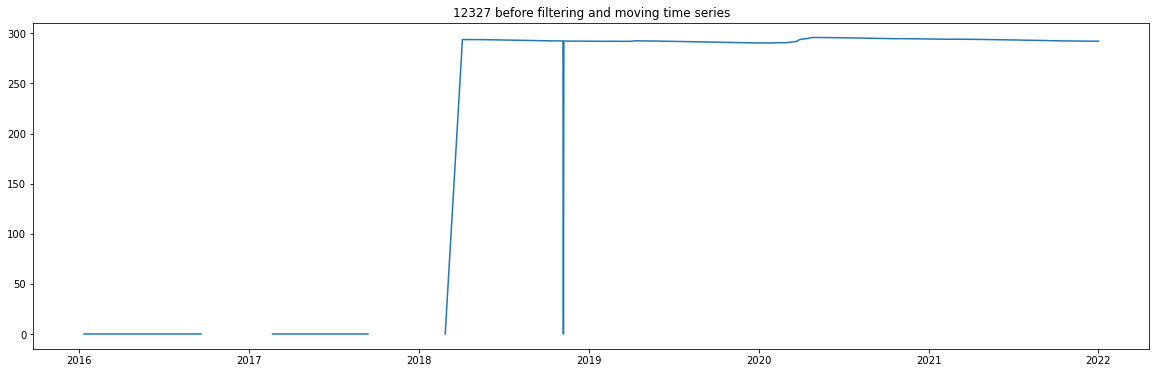

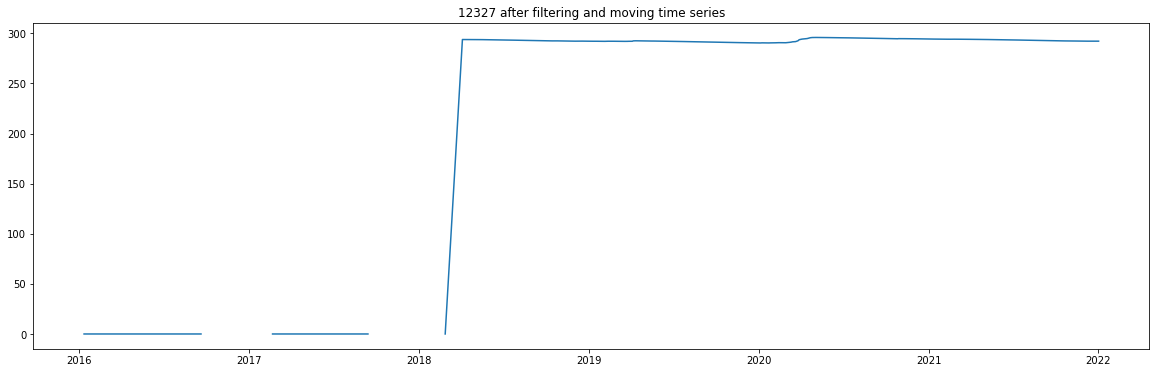

In [90]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'
low_lim=-5
high_lim=5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
df1=df_ground_ex
title=' filtering and moving time series'
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Subset the time series to a period after 2018-04 station 12327
#### Reason: It seems a problem with the reference value at the begginning of the time series

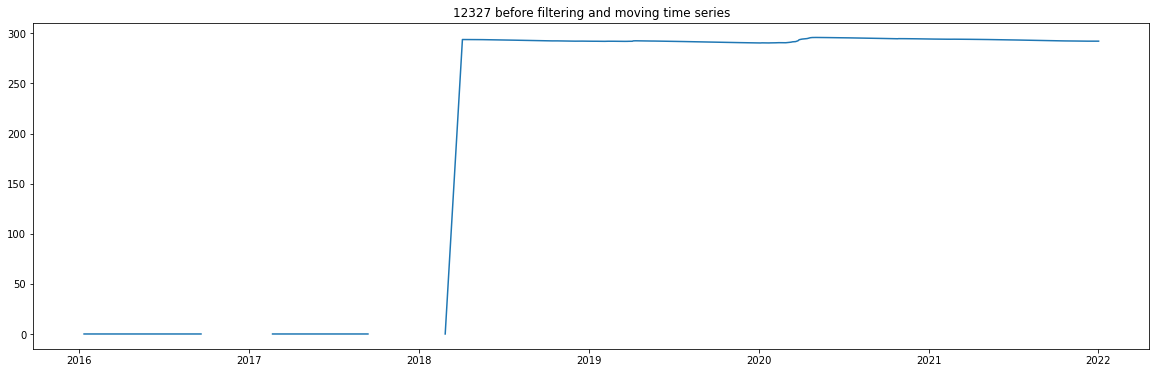

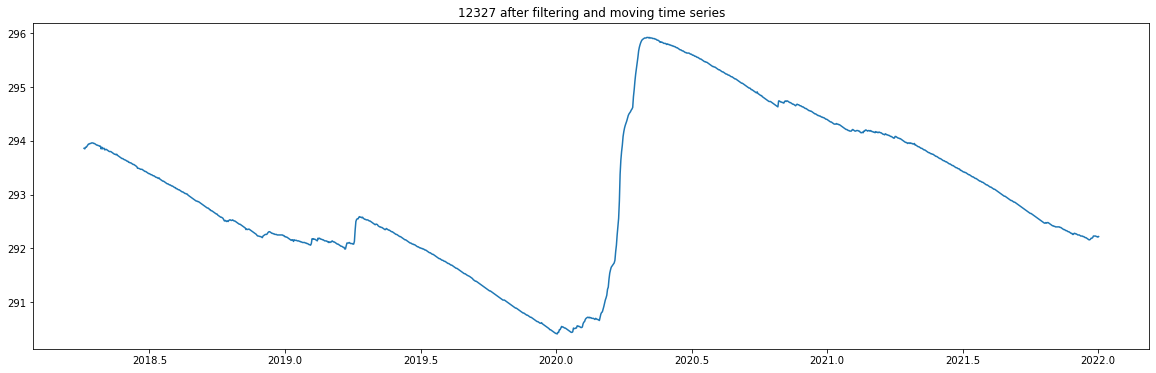

In [91]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

df1=df.loc[df['date']>'2018-04-04'] #This is the date when the big Jump occurs. Therefore the plot will be filtered from here 
df1=df1.sort_values(by=date_fd)

df_ground_ts=pd.concat((df_ground_re,df1), axis=0)


title=' filtering and moving time series'
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Extract anomalous values station 12056
#### Reason: Differences of up to 8 m in a day

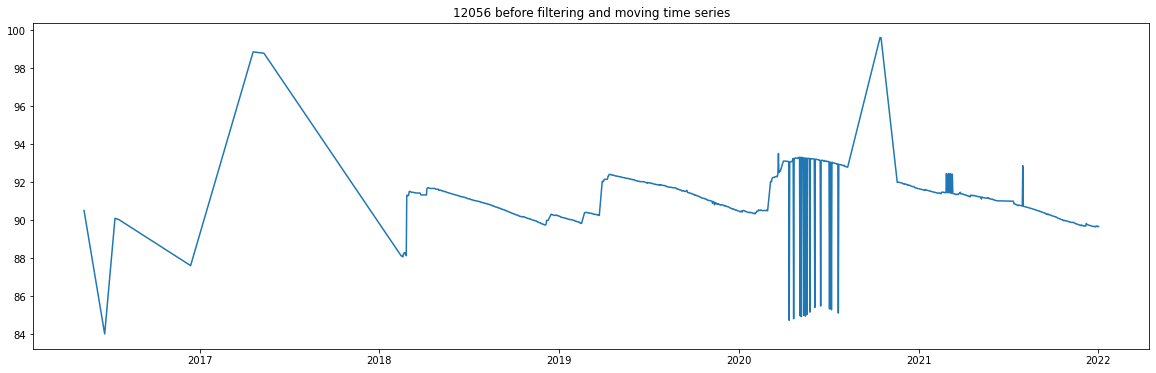

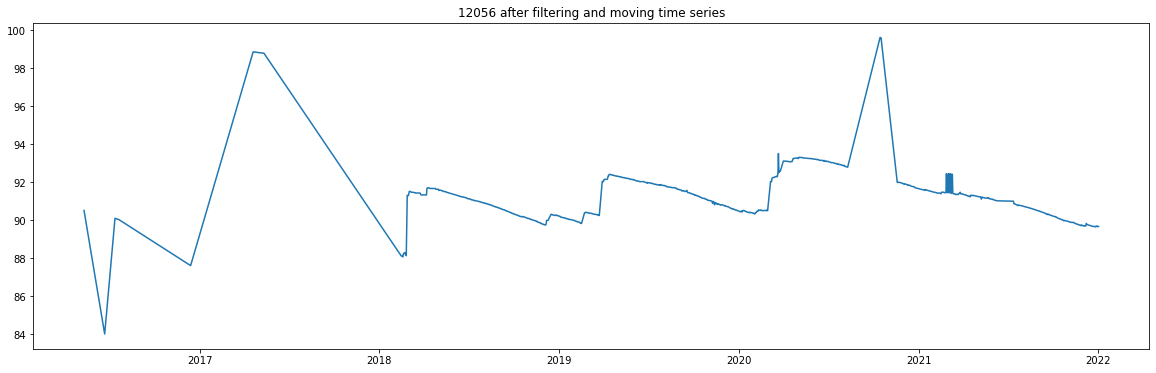

In [92]:
df=df_ground_ts.copy()
st_id='12056'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

low_lim=-1.5
high_lim=1.5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

#Extract from this gauge those that are with differences more than 8 m in about a day
dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]

#Date to remove 2020-05-07 because it is the only one in the middle of two days in which the change in water elevation was over 8.0 m
df_ground_fixed=df_ground_fixed.loc[df_ground_fixed['date']!='2020-05-07']

df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

title=' filtering and moving time series'
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


In [31]:
df_ground_ts.columns

Index(['gauge_id', 'source', 'decimal_y', 'height', 'date', 'year', 'month',
       'day', 'hour', 'doy', 'Hylak_id', 'SLIDE_snowIce', 'diff', 'diff_time'],
      dtype='object')

# 4. Save dataframe will all the time series preprocessed 

In [93]:
time_file=datetime.now().strftime("%Y%m%d_%H_%M")
df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')
#Backup
df_ground_ts.to_csv('../data/results/data_preprocessed_'+time_file+'.csv', sep=',')

# 5. Preprocess altis data of the selected lakes 

In [121]:
#Test to determine potential number of figures
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")

df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
    

tf=TimezoneFinder()

#Filter to lakes approved
#---------------------------
# approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']

#HURRY Parch code so it works with the new gauges at the two lakes that have two gauges
# Fix, modify the shapefile so it can get the coordinates of the two gauges
f=[df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].copy(),pd.Series(['VCN2', 'FDN2'], name='gauge_id')]
approve_locss =pd.concat(f, axis=0)

altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

lon_fd='lon'
lat_fd='lat'

df_gts=df_ground_ts.copy()

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
i=1

#################CHANGE WITH N COMPARISON ####################
#----ALL
this_source='ALL'

#----ARHN
# this_source='ARHN'

##---LOCSS
# this_source='LOCSS'

#---USGS
# this_source='USGS'

##----RVBR
# this_source='RVBR'

#-----ICECV

# this_source='ICECV'
###########################################################

if this_source not in ['ALL', 'ICECV']:
    altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

data_source=this_source

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Lake ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        lake_name=df_ground_st['lake_name'].iloc[0]
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name
        
        #Get the dates of altis
        # ic(df_altis[altis_date_fd].dt.normalize().max())
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

#         
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        median_fd='median_d_'+str(delta)
        mean_fd='mean_d_'+str(delta)
        std_fd='std_d_'+str(delta)
        mad_fd='mad_d_'+str(delta) #Median absolute deviation
        count_fd='count_d_'+str(delta)
        
        #second approach, the closest date
        delta=5
        val_cd_fd='val_cd_d_'+str(delta)
        criteria_fd='type_cd_d_'+str(delta)
        closer_dt_fd='ndays_cd_d_'+str(delta)
        mea_cd_fd='mea_cd_d_'+str(delta)
        std_cd_fd='std_cd_d_'+str(delta)
        mad_cd_fd='mad_cd_d_'+str(delta) #Median absolute deviation
        n_cd_fd='n_cd_d_'+str(delta)
        # Get moving windows
        df_altis_c[[median_fd,mad_fd, mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)
        
        # Get closer value around a date
        df_altis_c[[val_cd_fd,criteria_fd,closer_dt_fd,mea_cd_fd, mad_cd_fd, std_cd_fd,n_cd_fd]]=df_altis_c.apply(lambda x: closer_value_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)
        #add columns
        df_altis_c['lake_name']=lake_name
        df_altis_c['source']=df_ground_c['source'].iloc[0]
        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
df_final_ground=df_final_ground.rename(columns={'altis_d_1':'name_altis'}, errors='raise')
df_final_altis=df_final_altis.rename(columns={'ground_st_1':'gauge_id'}, errors='raise')

Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 2028 ground_st: True df_altis: (104, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Lake ID: 2028 ground_st: True df_altis: (157, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 1824 ground_st: True df_altis: (73, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (76, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (75, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 2028 ground_st: True df_altis: (77, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2316 ground_st: True df_altis: (41, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN Lake ID: MTN2 ground_st: True df_altis: (44, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN Lake ID: FDN2 ground_st: True df_altis: (76, 8)
Station Antarctica/McMurdo ncolge

In [124]:
df_final_altis.name_altis.unique()

array(['AlTiS_TimeSeries_Jason-3_0215_S4017',
       'AlTiS_TimeSeries_Jason-3_GDR_F_0215_S4017',
       'AlTiS_TimeSeries_Sentinel-3A_0562_S4128',
       'AlTiS_TimeSeries_Sentinel-3A_0635_S4324',
       'AlTiS_TimeSeries_Sentinel-3A_0676_S4325',
       'AlTiS_TimeSeries_Sentinel-3A_0749_S4016',
       'AlTiS_TimeSeries_Sentinel-3B_0020_S4492',
       'AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549',
       'AlTiS_TimeSeries_Sentinel-3A_0149_N3577',
       'AlTiS_TimeSeries_Sentinel-3B_0622_N4234',
       'AlTiS_TimeSeries_Sentinel-3B_0622_N4194',
       'AlTiS_TimeSeries_Sentinel-3B_0549_N4183',
       'AlTiS_TimeSeries_Sentinel-3A_0637_N4783',
       'AlTiS_TimeSeries_Sentinel-3B_0691_N3466',
       'AlTiS_TimeSeries_Sentinel-3A_0522_N2294',
       'AlTiS_TimeSeries_Sentinel-3A_0636_N2354',
       'AlTiS_TimeSeries_Sentinel-3A_0026_N4756',
       'AlTiS_TimeSeries_Sentinel-3A_0035_N3493',
       'AlTiS_TimeSeries_Sentinel-3A_0193_N2515',
       'AlTiS_TimeSeries_Sentinel-3A_0351_N5346

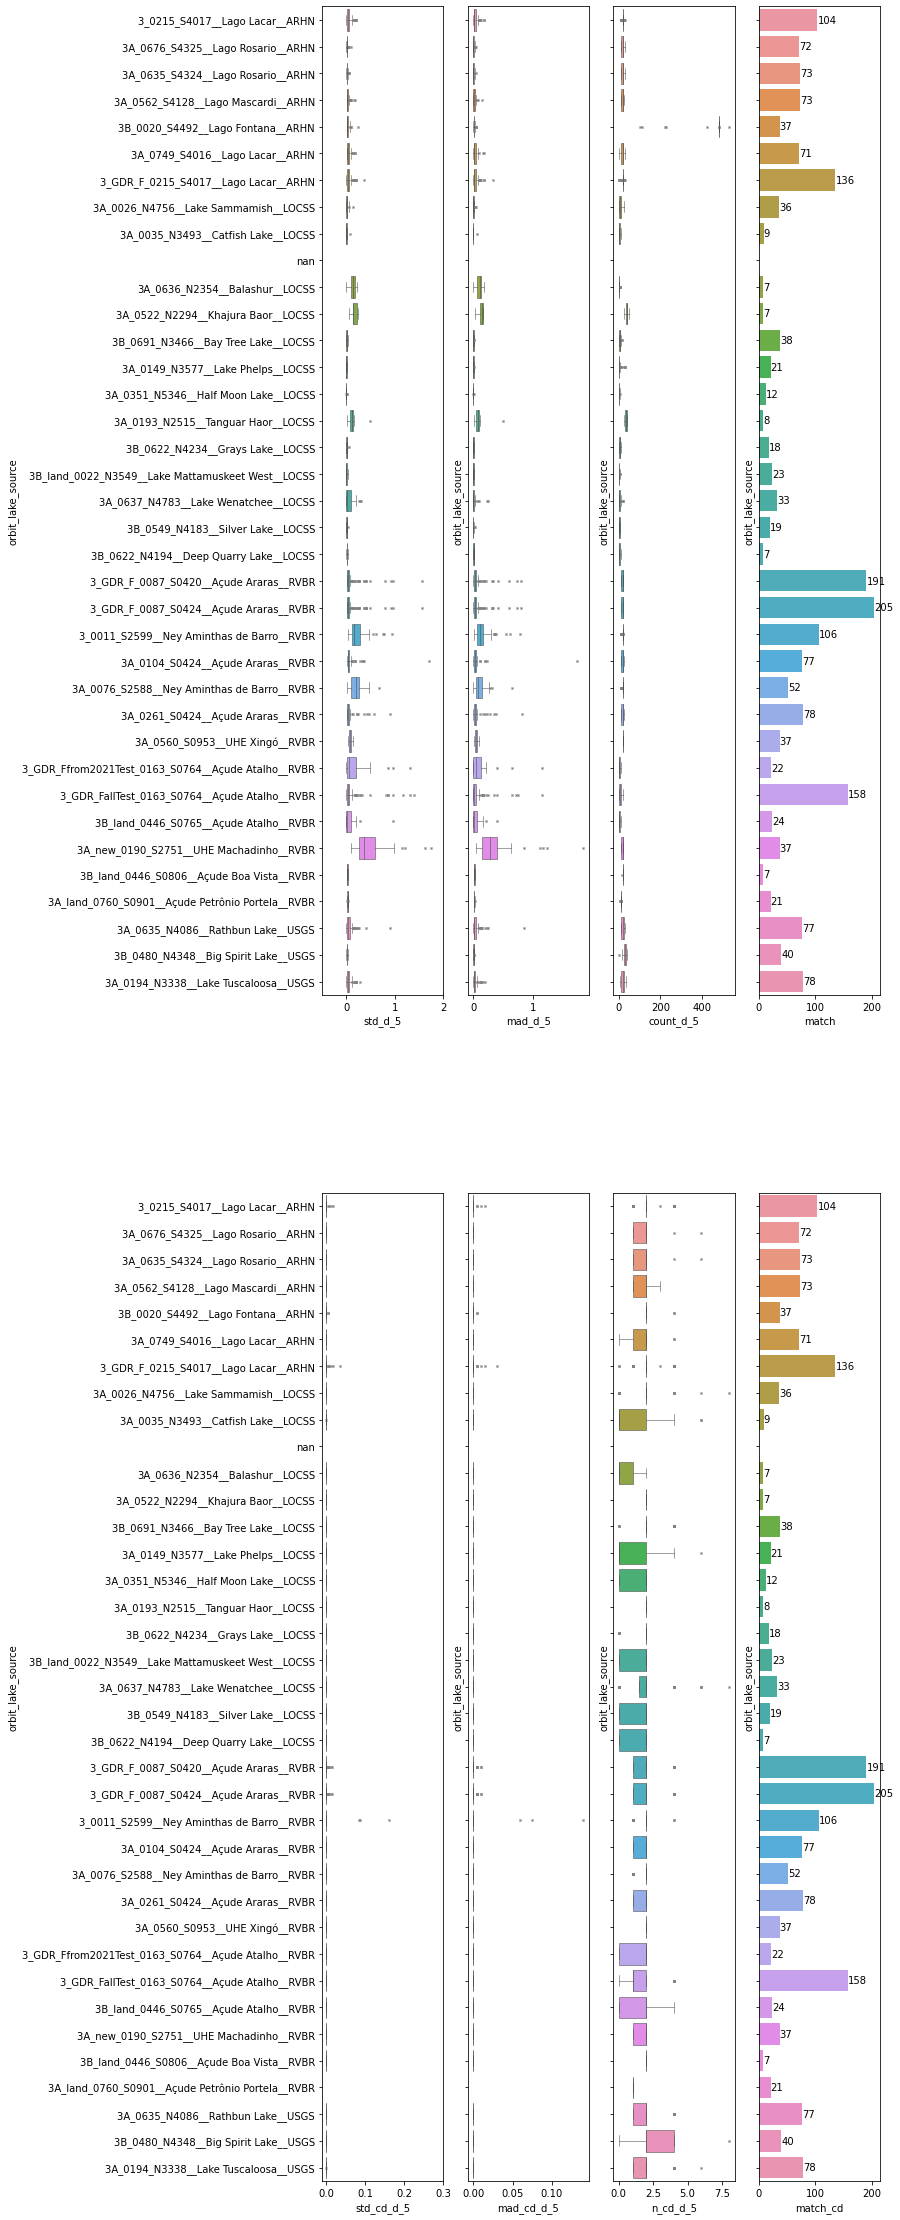

In [122]:
import seaborn as sns

names_field='name_altis'
data_field='std_d_5'

df=df_final_altis.copy()


df['orbit_lake_source']=[x.split('-')[1] for x in df[names_field]]
df['orbit_lake_source']=df['orbit_lake_source']+'__'+df['lake_name']+'__'+df['source']
df.sort_values(by=['source'], inplace=True, ascending=True)


names_field='orbit_lake_source'
y_order=df[names_field].unique()

flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='gray')

fig, axes = plt.subplots(2, 4, figsize=(10, 40), sharey=True)

g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,0],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[0,0].set_xlim(-0.5, 2)
# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='std_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,0],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[1,0].set_xlim(-0.01, .3)
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

data_field='mad_d_5'
g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,1],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[0,0].set_xlim(-0.5, 2)
# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='mad_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,1],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[1,0].set_xlim(-0.01, .3)
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

data_field='count_d_5'
g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,2],linewidth=0.5, flierprops=flierprops, order=y_order)
# axes[0].set_xlim(-0.5, 2)
# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='n_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,2],linewidth=0.5, flierprops=flierprops, order=y_order)
# axes[1].set_xlim(-0.01, .3)

df['match']=df[['height', 'median_d_5']].count(axis=1)
df.loc[df['match']==1, 'match']=np.nan
df.loc[df['match']==2, 'match']=1
df_count_obs=df[[names_field, 'match']].groupby(names_field).count().reset_index()

g=sns.barplot(data=df_count_obs,x='match',y=names_field, ax=axes[0,3], order=y_order)
for i in g.containers:
    g.bar_label(i,)

df['match_cd']=df[['height', 'val_cd_d_5']].count(axis=1)
df.loc[df['match_cd']==1, 'match_cd']=np.nan
df.loc[df['match_cd']==2, 'match_cd']=1
df_count_obs_cd=df[[names_field, 'match_cd']].groupby(names_field).count().reset_index()

g=sns.barplot(data=df_count_obs_cd,x='match_cd',y=names_field, ax=axes[1,3], order=y_order)    
for i in g.containers:
    g.bar_label(i,)


  


# 6. Generate the matching time series of ground and altimeter observations

In [125]:
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
df_final_ground.to_csv('../data/results/preprossed_ground_data_'+time_fig+'.csv', sep=',')
df_final_altis.to_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',')

In [126]:
time_fig

'20221109_19_13'